# iTEBD

In [16]:
import pyuni10 as uni10
import numpy as np
import random as rnd
from scipy import linalg
from matplotlib import pyplot as plt
%matplotlib inline

## Construct Hamiltonian
Construct the Hamiltonian for 1D transverse Ising model
\begin{equation}
H = \sum_{\langle ij\rangle} \sigma^z_i \sigma^z_j + h\sum_i \sigma^x_i
\end{equation}

In [17]:
## Define virtual and physical bond dimension
pdim = 2
vdim = 10

## Constructor in-bond and out-bond
p_bdi = uni10.Bond(uni10.BD_IN, pdim)
p_bdo = uni10.Bond(uni10.BD_OUT, pdim)
v_bdi = uni10.Bond(uni10.BD_IN, vdim)
v_bdo = uni10.Bond(uni10.BD_OUT, vdim)

Sz = uni10.UniTensorR([p_bdi, p_bdo])
Sx = uni10.UniTensorR([p_bdi, p_bdo])
Id = uni10.UniTensorR([p_bdi, p_bdo])

Sz.PutBlock(np.array([1, 0, 0, -1]).reshape((2, 2)))
Sx.PutBlock(np.array([0, 1, 1, 0]).reshape((2, 2)))
Id.PutBlock(np.identity(2))

## Set h = 1.2
H = uni10.Otimes(Sz, Sz) + 1.2 * (uni10.Otimes(Sx, Id) + uni10.Otimes(Id, Sx))
print(H)


************************************
REAL(1)

             ____________
            |            |
        0___|2          2|___2    
            |            |   
        1___|2          2|___3    
            |            |   
            |____________|

================BONDS===============
IN : (U1 = 0, P = 0, 0)|2, Dim = 2
IN : (U1 = 0, P = 0, 0)|2, Dim = 2
OUT: (U1 = 0, P = 0, 0)|2, Dim = 2
OUT: (U1 = 0, P = 0, 0)|2, Dim = 2

===============BLOCKS===============
--- (U1 = 0, P = 0, 0): 
4 x 4 = 16 [ Real ElemNum: 0 ], REAL

[ 
   1.0000   1.2000   1.2000   0.    
   1.2000  -1.0000   0.       1.2000
   1.2000   0.      -1.0000   1.2000
   0.       1.2000   1.2000   1.0000
];
Total elemNum: 16





## Construct Lambda and Gamma Tensors

In [18]:
lams = [uni10.UniTensorR([v_bdi, v_bdo]), uni10.UniTensorR([v_bdi, v_bdo])]
gams = [uni10.UniTensorR([v_bdi, p_bdi, v_bdo]), uni10.UniTensorR([v_bdi, p_bdi, v_bdo])]
lams[0].Identity()
lams[1].Identity()
gams[0].Randomize()
gams[1].Randomize()
lams[0].PrintDiagram()
lams[1].PrintDiagram()
gams[0].PrintDiagram()
gams[1].PrintDiagram()

************************************
REAL

             ____________
            |            |
        0___|10        10|___1    
            |            |   
            |____________|

================BONDS===============
IN : (U1 = 0, P = 0, 0)|10, Dim = 10
OUT: (U1 = 0, P = 0, 0)|10, Dim = 10


Total elemNum: 100
************************************
REAL

             ____________
            |            |
        0___|10        10|___1    
            |            |   
            |____________|

================BONDS===============
IN : (U1 = 0, P = 0, 0)|10, Dim = 10
OUT: (U1 = 0, P = 0, 0)|10, Dim = 10


Total elemNum: 100
************************************
REAL

             ____________
            |            |
        0___|10        10|___2    
            |            |   
        1___|2           |
            |            |   
            |____________|

================BONDS===============
IN : (U1 = 0, P = 0, 0)|10, Dim = 10
IN : (U1 = 0, P = 0, 0)|2, Dim = 2
OUT

## Network
A Network can be read from `.net` files

In [19]:
theta_net = uni10.Network("theta.net")
lglgl_net = uni10.Network("lglgl.net")

## Set Simulation Parameters
* dt - step of time
* steps - iteration numbers

In [20]:
dt = 0.01
steps = 2000

## Construct Imaginary Time Evolution Operator
\begin{equation}
U = \exp^{-H\tau}
\end{equation}

In [21]:
Evol = uni10.UniTensorR(H.bond())
Evol.PutBlock(linalg.expm(-dt * H.GetBlock()))
print(Evol)


************************************
REAL(1)

             ____________
            |            |
        0___|2          2|___2    
            |            |   
        1___|2          2|___3    
            |            |   
            |____________|

================BONDS===============
IN : (U1 = 0, P = 0, 0)|2, Dim = 2
IN : (U1 = 0, P = 0, 0)|2, Dim = 2
OUT: (U1 = 0, P = 0, 0)|2, Dim = 2
OUT: (U1 = 0, P = 0, 0)|2, Dim = 2

===============BLOCKS===============
--- (U1 = 0, P = 0, 0): 
4 x 4 = 16 [ Real ElemNum: 0 ], REAL

[ 
   0.9902  -0.0120  -0.0120   0.0001
  -0.0120   1.0102   0.0001  -0.0120
  -0.0120   0.0001   1.0102  -0.0120
   0.0001  -0.0120  -0.0120   0.9902
];
Total elemNum: 16





## Simulation

In [22]:
E_list = []
for step in range(steps):
    ia = step%2
    ib = (step+1)%2
    
    # Theta
    theta_net.PutTensor("LamA", lams[ia])
    theta_net.PutTensor("LamB", lams[ib])
    theta_net.PutTensor("GamA", gams[ia])
    theta_net.PutTensor("GamB", gams[ib])
    theta_net.PutTensor("U", Evol)
    theta = uni10.UniTensorR([]) #empty tensor
    theta_net.Launch(theta)
    
    # SVD
    U, S, V = linalg.svd(theta.GetBlock())
    
    # Truncation
    U = U[:, :vdim]
    S = S[:vdim]
    V = V[:vdim, :]
    
    # Update GammaA, GammaB and LambdaA
    bds = theta.bond()
    gams[ia].Assign([bds[0], bds[1], uni10.Bond(uni10.BD_OUT, vdim)])
    lams[ia].Assign([uni10.Bond(uni10.BD_IN, vdim), uni10.Bond(uni10.BD_OUT, vdim)])
    gams[ib].Assign([uni10.Bond(uni10.BD_IN, vdim), bds[2], bds[3]])
    
    gams[ia].PutBlock(U)
    lams[ia].PutBlock(np.diag(S) / linalg.norm(S))
    gams[ib].PutBlock(V)
    
    gams[ib] = uni10.Permute(gams[ib], 2)
    
    # Calculate energy
    bra = uni10.UniTensorR([])
    ket = uni10.UniTensorR([])
    
    theta_net.PutTensor("LamA", lams[ia])
    theta_net.PutTensor("LamB", lams[ib])
    theta_net.PutTensor("GamA", gams[ia])
    theta_net.PutTensor("GamB", gams[ib])
    theta_net.PutTensor("U", H)
    theta_net.Launch(ket)
    
    lglgl_net.PutTensor("LamA", lams[ia])
    lglgl_net.PutTensor("LamB", lams[ib])
    lglgl_net.PutTensor("GamA", gams[ia])
    lglgl_net.PutTensor("GamB", gams[ib])
    lglgl_net.Launch(bra)
    
    bra.SetLabel([1, 2, 3, 4])
    ket.SetLabel([1, 2, 3, 4])
    E = uni10.Contract(bra, ket).GetElem()[0]
    E_list.append(E)
    
    if step % 100 == 0:
        print("E = ", E)

E =  -0.212908913666
E =  -2.23014409076
E =  -2.38324721098
E =  -2.40608627365
E =  -2.41340322231
E =  -2.41619583376
E =  -2.4173357667
E =  -2.41781407976
E =  -2.41801711654
E =  -2.41810372771
E =  -2.41814075184
E =  -2.41815659296
E =  -2.41816337333
E =  -2.41816627596
E =  -2.41816751865
E =  -2.41816805069
E =  -2.41816827848
E =  -2.418168376
E =  -2.41816841776
E =  -2.41816843564


(0, 2000)

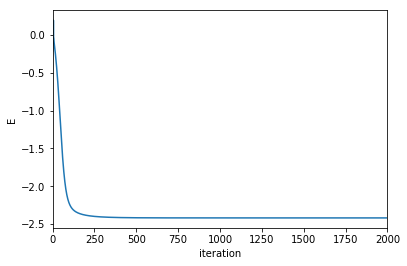

In [24]:
plt.plot(E_list)
plt.xlabel("iteration")
plt.ylabel("E")
plt.xlim(0, steps)